<a href="https://colab.research.google.com/github/Rishal14/Image_Removal_Restoration/blob/main/Noise_removal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:

from google.colab import files
uploaded = files.upload()

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

image_path = next(iter(uploaded))
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)


rows, cols = image.shape
x = np.arange(rows)
y = np.arange(cols)
x, y = np.meshgrid(x, y, indexing='ij')


frequency = 16
amplitude = 50
periodic_noise = amplitude * np.sin(2 * np.pi * frequency * y / cols)

noisy_image = image + periodic_noise
noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

f = np.fft.fft2(noisy_image)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)

def notch_reject_filter(shape, centers, radius=5):
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    mask = np.ones((rows, cols), dtype=np.float32)
    for cx, cy in centers:
        for i in range(rows):
            for j in range(cols):
                if ((i - crow - cx)**2 + (j - ccol - cy)**2) <= radius**2 or \
                   ((i - crow + cx)**2 + (j - ccol + cy)**2) <= radius**2:
                    mask[i, j] = 0
    return mask

notch_centers = [(0, frequency), (0, -frequency)]
mask = notch_reject_filter(image.shape, notch_centers, radius=5)

fshift_filtered = fshift * mask
f_ishift = np.fft.ifftshift(fshift_filtered)
img_back = np.fft.ifft2(f_ishift)
filtered_image = np.abs(img_back)
filtered_image = np.clip(filtered_image, 0, 255).astype(np.uint8)
psnr_value = psnr(image, filtered_image)
ssim_value = ssim(image, filtered_image)

print(f"📊 PSNR: {psnr_value:.2f} dB")
print(f"📊 SSIM: {ssim_value:.4f}")





Saving 300px-Kodim17_noisy.jpg to 300px-Kodim17_noisy (1).jpg
📊 PSNR: 30.47 dB
📊 SSIM: 0.9301


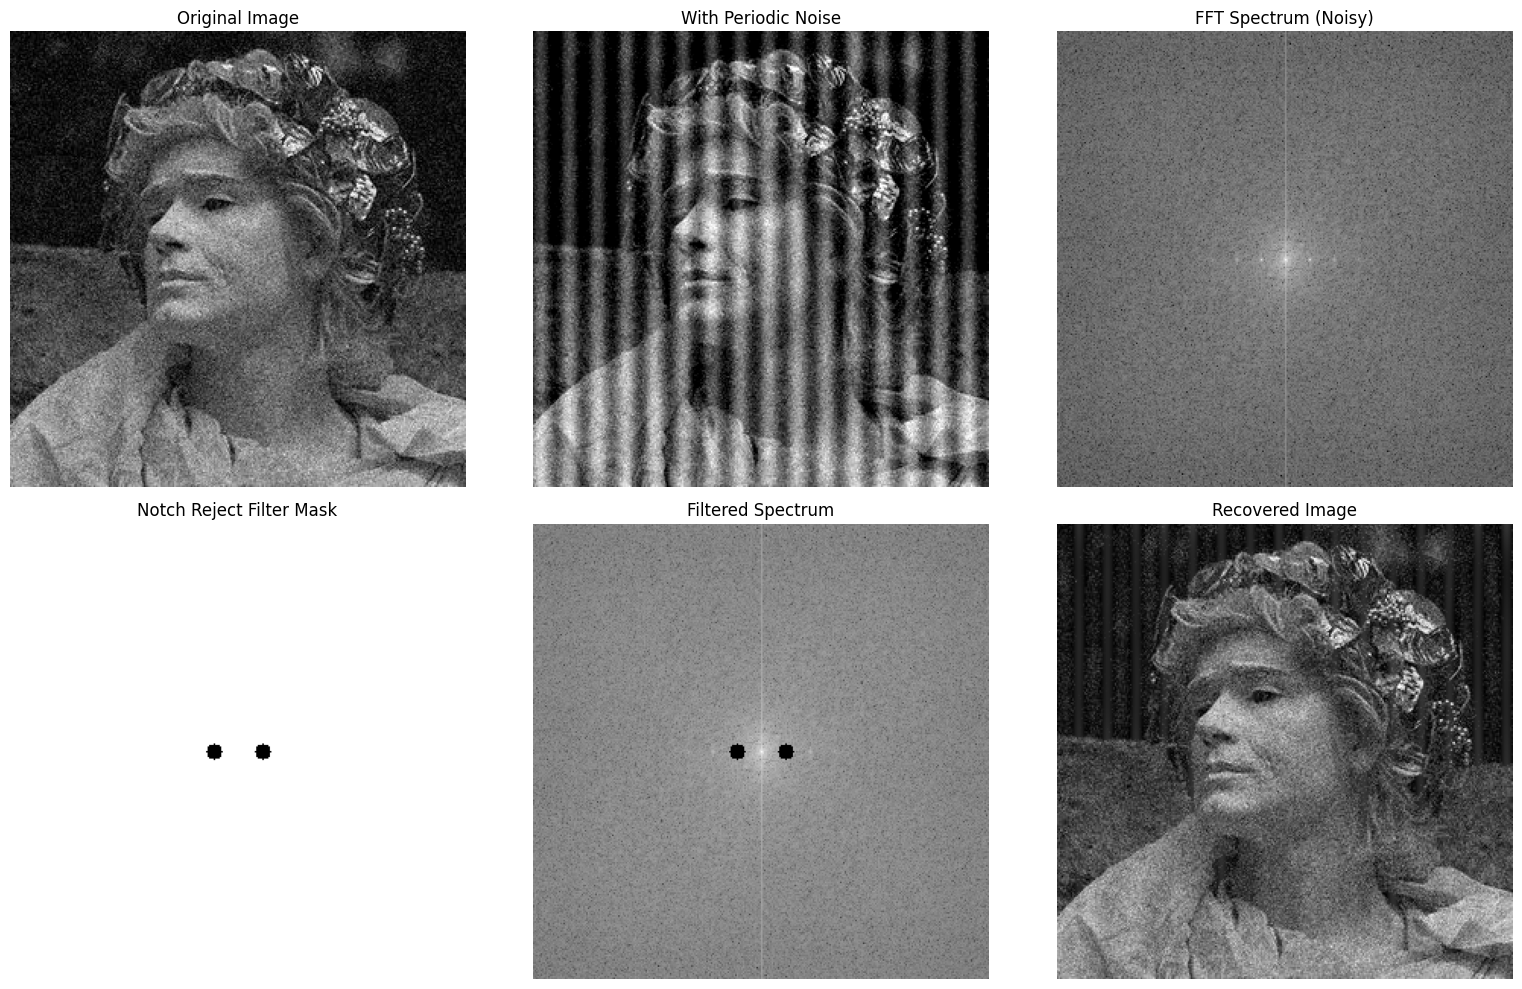

In [11]:
plt.figure(figsize=(16, 10))

plt.subplot(2, 3, 1)
plt.imshow(image, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(noisy_image, cmap='gray')
plt.title("With Periodic Noise")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title("FFT Spectrum (Noisy)")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(mask, cmap='gray')
plt.title("Notch Reject Filter Mask")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(np.log(np.abs(fshift_filtered) + 1), cmap='gray')
plt.title("Filtered Spectrum")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(filtered_image, cmap='gray')
plt.title("Recovered Image")
plt.axis('off')

plt.tight_layout()
plt.show()